# Names 
Spencer Bernardo-Cheng
Max Goldstein
Robbie Keehan

# Data Preparation

Our dataset is used to predict the price of Amazon. In the dataset, we used the opening and closing prices of Amazon, Google, Microsoft, Netflix, and Facebook. We used other tech companies to provide the model with information about the tech company sector of the stock market. We also used common market indicators such as the SMA-7, SMA-21, SMA-90, RSI-14, and ADX. All of these combined are used to predict the percent change in price for the next days closing price. The data is modified to all be in percentage change, so that the model does not simply learn to predict the price of the next day based mostly off of the previous day. We challenge the RNN to determine price change as opposed price values.

In [1]:
import numpy as np
import pandas as pd
datafb = pd.read_csv("./FB.csv")
datagoogle = pd.read_csv("./GOOGL.csv")
datamsft = pd.read_csv("./MSFT.csv")
dataam = pd.read_csv("./AMZN (1).csv")
datanflx = pd.read_csv("./NFLX.csv")

del datafb['Date']
del datagoogle['Date']
del datamsft['Date']
del datanflx['Date']


data = pd.concat([datafb, datagoogle, datamsft,datanflx, dataam ], axis=1, sort=False)
data = data[89:]
del data['Change']
del data['Gain']
del data['Loss']
del data['Average Gain']
del data['Average Loss']
del data['RS']
del data['DM+1']
del data['DM-1']
del data['TR-14']
del data['DM+1-14']
del data['DM-1+14']
del data['dl+1-14']
del data['dl-1-14']
del data['dl14diff']
del data['dl14sum']
del data['DX']
del data['TR']
ogdates = []
for val in data['Date']:
    ogdates.append(val)
del data['Date']

predictedDays = 14
up = .03
down =-.03
## Time difference the data
colheaders = data.columns[0:-3]
og = []
for val in data['Close-amzn']:
    og.append(val)
for header in colheaders: 
    for i in range(1, len(data)):
        perchange =((data[header].iloc[i]) - (data[header].iloc[i - 1]))/float(data[header].iloc[i-1])
        data.set_value(89+i,"pc-"+header,perchange)
#         data["pc"+header].at[90+i]= perchange
data = data[1:]
ydata = data['pc-Close-amzn']
# ydata = ydata.apply(lambda x:2 if x>=up else (1 if (x< up and x > down) else 0))
ydata = pd.DataFrame(ydata)
ydata['newy'] = ""
# created target data in format to match output of multiple timesteps of 14 days ahead
# [0,1,2,3,4,5,6,7]
# [1,2,3,4,5,6,7,8]
for index, row in ydata.iterrows():
    temp = np.array(ydata['pc-Close-amzn'][index-90:index-90+predictedDays].values)
    ydata['newy'].at[index] = temp
    
# removed last 14 because their targets are not able to created
ydata = ydata[0:-(predictedDays-1)]
data = data[0:-(predictedDays-1)]

del ydata['pc-Close-amzn']

xdata =data[['RSI-14 Day', 'ADX',
       'pc-Open-fb', 'pc-High-fb', 'pc-Low-fb', 'pc-Close-fb',
       'pc-Adj Close-fb', 'pc-Volume-fb', 'pc-Open-googl', 'pc-High-googl',
       'pc-Low-googl', 'pc-Close-googl', 'pc-Adj Close-googl',
       'pc-Volume-googl', 'pc-Open-msft', 'pc-High-msft', 'pc-Low-msft',
       'pc-Close-msft', 'pc-Adj Close-msft', 'pc-Volume-msft', 'pc-Open-nflx',
       'pc-High-nflx', 'pc-Low-nflx', 'pc-Close-nflx', 'pc-Adj Close-nflx',
       'pc-Volume-nflx', 'pc-Open-amzn', 'pc-High-amzn', 'pc-Low-amzn',
       'pc-Close-amzn', 'pc-Adj Close-amzn', 'pc-Volume-amzn', 'pc-SMA-7',
       'pc-SMA-21', 'pc-SMA-90']]


data = data[0:-1]
xdata = xdata[0:-1]
ydata = ydata[0:-1]
# data = data.T


//anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:50: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


# Evaluation Criteria
We believe that using mean squared error is the best evaluation criteria for our use case of stock trading and because our model is performing a regression task as opposed to a classification task. If the stock prediction is too high or too low in either direction then it will result in sub-optimal trades. We decided to do mean squared error instead mean absolute error because the larger the error than the more that the trade could cost us. 

# Min-Max Scaling the Time Series

Scaling the data became necessary so as to prevent the model from thinking that higher prices have a higher significance in the model

In [3]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(xdata.iloc[:,:].values)
print(x_scaled)



[[0.35811382 0.15022488 0.40722014 ... 0.53721892 0.45230866 0.64160589]
 [0.26414926 0.12331708 0.35961381 ... 0.50635447 0.41867806 0.57327146]
 [0.25300192 0.10448737 0.40286589 ... 0.51153038 0.41312322 0.576277  ]
 ...
 [0.3029723  0.1344608  0.461637   ... 0.50352112 0.48231708 0.23750753]
 [0.31038595 0.1153046  0.38866776 ... 0.50862139 0.47320208 0.21748327]
 [0.25243424 0.13533161 0.42314792 ... 0.49730187 0.44639693 0.21806241]]


# Utilizing Time Series Generator

This time series generator function helped format our x data into chunks of 90 days for which we are to then predict the following 14 days. 

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Lambda, Dropout,GRU
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 2
series = np.array(x_scaled)
target = np.array(ydata)
generator = TimeseriesGenerator(series, target, length=90, batch_size=1)
xtime = []
ytarget =[]
for i in range(len(generator)):
    x, y = generator[i]
    xtime.append(x[0])
xtime = np.array(xtime)

target = target[90:]
newtarget = []
for val in target:
    newtarget.append(np.array(val[0]))
ytarget = np.array(newtarget)
print(ytarget.shape)


(1698, 14)


# 10 Fold Cross Validation

We did 10  folds because our dataset was small and only included 1788 data points. This enabled us to get see if the model would make accurate predictions at any point in time throughout our dataset and not concentrate on only the last 20% of the dataset. Although our dataset is timeseries, and 10 fold would be untraditional, we believe that any 90 day period  should be considered independent to another 90 day period to predict the following 14 days of price action. 

# LSTM

In [61]:
from sklearn.model_selection import KFold



kfold = KFold(n_splits=10, shuffle=False, random_state=None)
# fit model
historiesLSTM = []
# scores = []
lstmModels=[]
k = 1
# for train_index, test_index in kfold.split(xtime, ytarget):
for train_index, test_index in kfold.split(xtime, ytarget):
    model = Sequential()
    model.add(LSTM(100,dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
    model.add(Lambda(lambda x: x[:, -predictedDays:, :]))
    model.add(Dense(1))

    model.summary()
    model.compile(optimizer='adam', loss='mse')
    print("Fold: ", k)
    x_train, x_test = xtime[train_index], xtime[test_index]
    y_train, y_test = ytarget[train_index], ytarget[test_index]
    print(y_train.shape)
    y_train = y_train.reshape(y_train.shape[0],14,1)
    y_test= y_test.reshape(y_test.shape[0],14,1)
    
    historiesLSTM.append(model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=5, verbose=1))
    lstmModels.append(model)
    k += 1
#     score = model.score(x_train[test_index], y_train[test_index])
#     scores.append(score)
#     print('Fold: %s, Acc: %.3f' % (k+1, score))
    
# print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 90, 100)           54400     
_________________________________________________________________
lambda_76 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_76 (Dense)             (None, 14, 1)             101       
Total params: 54,501
Trainable params: 54,501
Non-trainable params: 0
_________________________________________________________________
Fold:  1
(1528, 14)
Train on 1528 samples, validate on 170 samples
Epoch 1/5
1528/1528 [==============================] - 16s 10ms/step - loss: 0.0027 - val_loss: 4.3135e-04
Epoch 2/5
1528/1528 [==============================] - 4s 3ms/step - loss: 6.6041e-04 - val_loss: 3.4477e-04
Epoch 3/5
1528/1528 [==============================] - 4s 3ms/step - loss: 5.5543e-04 - val_loss: 2.9135e-04
Epoch 4/5


Train on 1528 samples, validate on 170 samples
Epoch 1/5
1528/1528 [==============================] - 17s 11ms/step - loss: 0.0030 - val_loss: 2.5420e-04
Epoch 2/5
1528/1528 [==============================] - 4s 3ms/step - loss: 6.5561e-04 - val_loss: 3.0837e-04
Epoch 3/5
1528/1528 [==============================] - 4s 3ms/step - loss: 5.2022e-04 - val_loss: 2.3785e-04
Epoch 4/5
1528/1528 [==============================] - 4s 3ms/step - loss: 4.6700e-04 - val_loss: 2.5166e-04
Epoch 5/5
1528/1528 [==============================] - 4s 3ms/step - loss: 4.4515e-04 - val_loss: 2.1365e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 90, 100)           54400     
_________________________________________________________________
lambda_83 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_83 (Dens

# LSTM Validation & Training Loss Per Fold

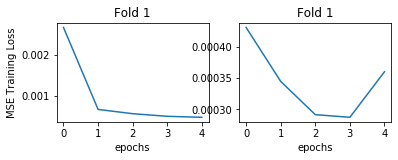

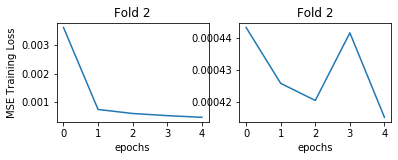

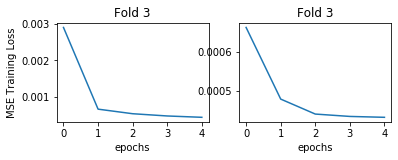

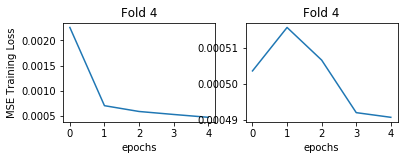

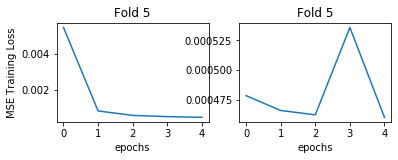

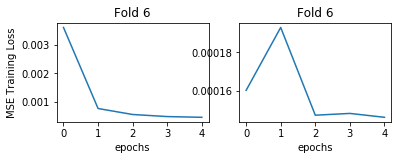

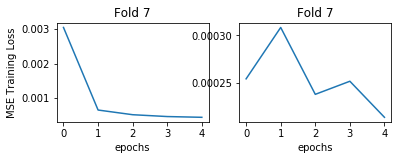

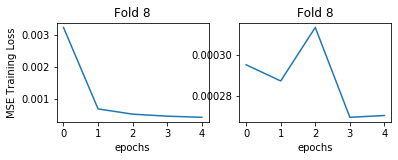

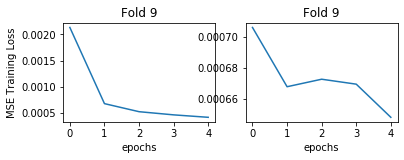

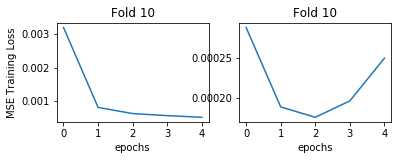

In [62]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesLSTM):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1))
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.title("Fold " + str(i+1))

    plt.xlabel('epochs')
    plt.show()

# GRU

In [18]:
from keras.layers import LSTM, Lambda, Dropout,GRU



kfold = KFold(n_splits=10, shuffle=False, random_state=None)
# fit model
historiesGRU = []
# scores = []

k = 1
# for train_index, test_index in kfold.split(xtime, ytarget):
gruModels=[]
for train_index, test_index in kfold.split(xtime, ytarget):
    gru = Sequential()
    gru.add(GRU(100,dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
    gru.add(Lambda(lambda x: x[:, -predictedDays:, :]))
    gru.add(Dense(1))

    gru.summary()
    gru.compile(optimizer='adam', loss='mse')
    print("Fold: ", k)
    x_train, x_test = xtime[train_index], xtime[test_index]
    y_train, y_test = ytarget[train_index], ytarget[test_index]
    y_train = y_train.reshape(y_train.shape[0],14,1)
    y_test= y_test.reshape(y_test.shape[0],14,1)
    
    historiesGRU.append(gru.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=5, verbose=1))
    gruModels.append(gru)
    k += 1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 90, 100)           40800     
_________________________________________________________________
lambda_43 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_43 (Dense)             (None, 14, 1)             101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Fold:  1
Train on 1528 samples, validate on 170 samples
Epoch 1/5
1528/1528 [==============================] - 10s 7ms/step - loss: 0.0120 - val_loss: 6.6369e-04
Epoch 2/5
1528/1528 [==============================] - 4s 2ms/step - loss: 0.0016 - val_loss: 4.2059e-04
Epoch 3/5
1528/1528 [==============================] - 4s 3ms/step - loss: 8.3761e-04 - val_loss: 3.3627e-04
Epoch 4/5
1528/1528 [=====

Fold:  7
Train on 1528 samples, validate on 170 samples
Epoch 1/5
1528/1528 [==============================] - 11s 7ms/step - loss: 0.0050 - val_loss: 3.0268e-04
Epoch 2/5
1528/1528 [==============================] - 4s 2ms/step - loss: 8.8528e-04 - val_loss: 2.4113e-04
Epoch 3/5
1528/1528 [==============================] - 3s 2ms/step - loss: 6.6603e-04 - val_loss: 2.6071e-04
Epoch 4/5
1528/1528 [==============================] - 3s 2ms/step - loss: 5.3184e-04 - val_loss: 2.2004e-04
Epoch 5/5
1528/1528 [==============================] - 3s 2ms/step - loss: 5.0365e-04 - val_loss: 2.1266e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 90, 100)           40800     
_________________________________________________________________
lambda_50 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_

# GRU Validation & Training Loss Per Fold

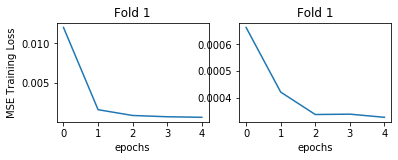

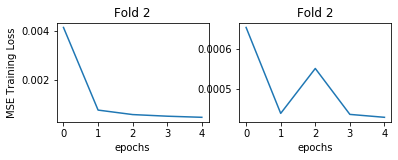

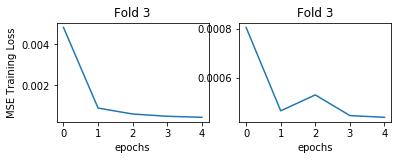

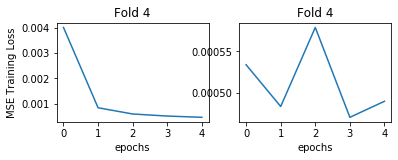

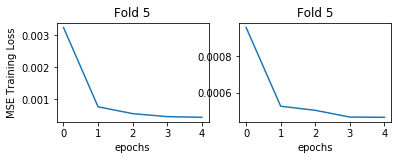

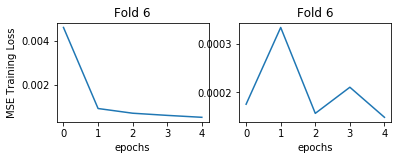

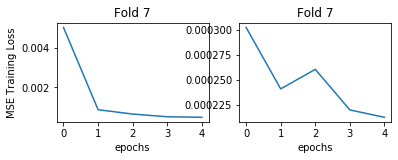

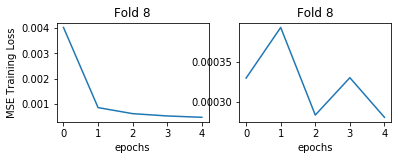

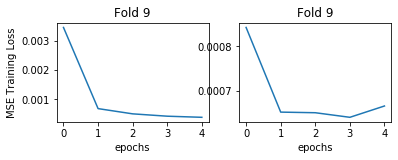

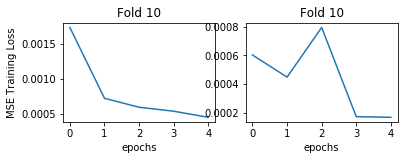

In [19]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesGRU):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1))
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.title("Fold " + str(i+1))

    plt.xlabel('epochs')
    plt.show()

# LSTM VS GRU - MSE

After reviewing the loss graphs generated per fold below, the GRU ended up with a lower loss or (MSE) than the LSTM, thus we decided to use the stacked GRU. This result makes sense as GRU's in general perform better on datasets with smaller sample sizes. We understand that when training these models, it is important to have many epochs. While developing the models,  prior to performing cross validation, we compared the performance of LSTM and GRU in the 300 epoch range. It became clear that the GRU performed better. We tested the GRU on 1k epochs and it started to perform very well without overfitting. As a result, whenever we implemented 10-fold cross validation, we did not have time to run a total of 30k epochs for 3 models. These results merely show our comparisons of the losses as we believe this metric is the most relevenat when comparing models attempting to tackle regression

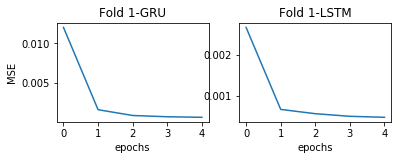

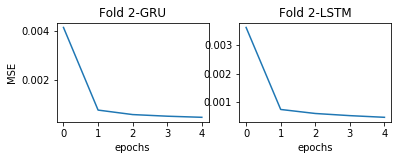

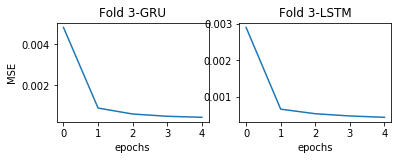

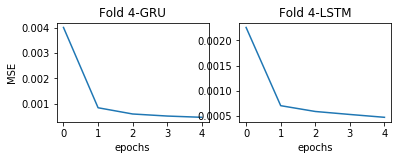

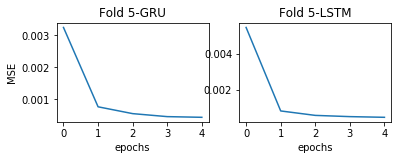

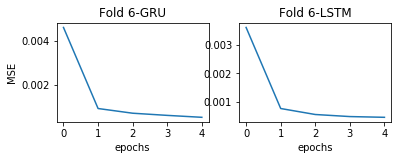

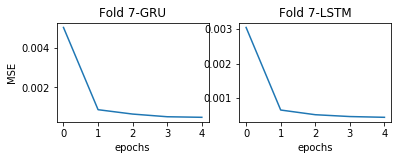

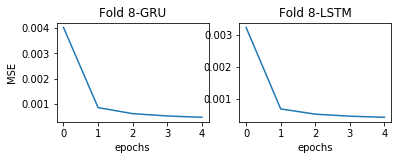

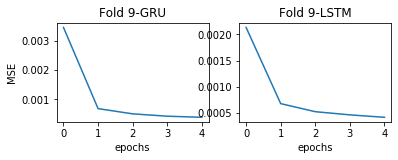

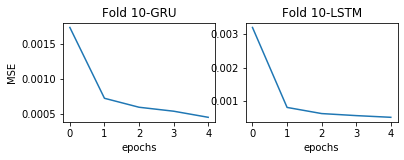

In [63]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesGRU):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1) + "-GRU")
    plt.ylabel('MSE')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(historiesLSTM[i].history['loss'])
    plt.title("Fold " + str(i+1)  + "-LSTM")
    plt.xlabel('epochs')
    plt.show()

# Stacked RNN

In [21]:



kfold = KFold(n_splits=10, shuffle=False, random_state=None)
# fit model
historiesStacked = []
stackedModels=[]
# scores = []

k = 1
# for train_index, test_index in kfold.split(xtime, ytarget):
for train_index, test_index in kfold.split(xtime, ytarget):
    modelstacked = Sequential()
    modelstacked.add(GRU(100,dropout=.2,recurrent_dropout=.2,activation='relu', input_shape=(90, 35), return_sequences=True))
    modelstacked.add(GRU(100,dropout=.4,activation='relu', return_sequences=True))

    modelstacked.add(Lambda(lambda x: x[:, -predictedDays:, :]))

    modelstacked.add(Dense(1))

    modelstacked.summary()
    modelstacked.compile(optimizer='adam', loss='mse')
    print("Fold: ", k)
    x_train, x_test = xtime[train_index], xtime[test_index]
    y_train, y_test = ytarget[train_index], ytarget[test_index]
    y_train = y_train.reshape(y_train.shape[0],14,1)
    y_test= y_test.reshape(y_test.shape[0],14,1)
    
    historiesStacked.append(modelstacked.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=5, verbose=1))
    stackedModels.append(modelstacked)
    k += 1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_21 (GRU)                 (None, 90, 100)           40800     
_________________________________________________________________
gru_22 (GRU)                 (None, 90, 100)           60300     
_________________________________________________________________
lambda_54 (Lambda)           (None, 14, 100)           0         
_________________________________________________________________
dense_54 (Dense)             (None, 14, 1)             101       
Total params: 101,201
Trainable params: 101,201
Non-trainable params: 0
_________________________________________________________________
Fold:  1
Train on 1528 samples, validate on 170 samples
Epoch 1/5
1528/1528 [==============================] - 17s 11ms/step - loss: 0.0040 - val_loss: 3.0464e-04
Epoch 2/5
1528/1528 [==============================] - 7s 5ms/step - loss: 8.3369e-04 - val_loss: 4.2092e

1528/1528 [==============================] - 18s 12ms/step - loss: 0.0014 - val_loss: 1.5749e-04
Epoch 2/5
1528/1528 [==============================] - 7s 5ms/step - loss: 4.8301e-04 - val_loss: 1.6592e-04
Epoch 3/5
1528/1528 [==============================] - 7s 5ms/step - loss: 4.4443e-04 - val_loss: 1.5335e-04
Epoch 4/5
1528/1528 [==============================] - 7s 5ms/step - loss: 4.0678e-04 - val_loss: 1.4809e-04
Epoch 5/5
1528/1528 [==============================] - 7s 5ms/step - loss: 3.9820e-04 - val_loss: 1.4755e-04
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_33 (GRU)                 (None, 90, 100)           40800     
_________________________________________________________________
gru_34 (GRU)                 (None, 90, 100)           60300     
_________________________________________________________________
lambda_60 (Lambda)           (None, 14, 100)           0         
_____

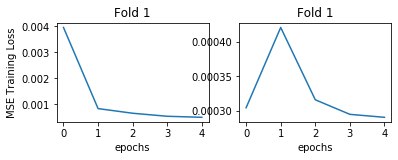

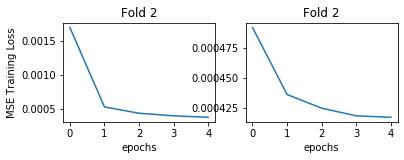

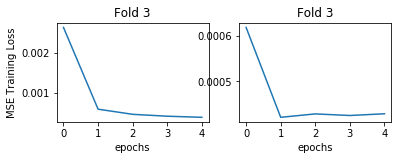

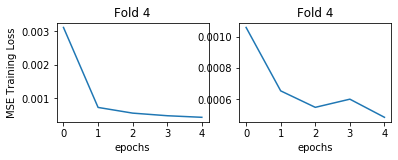

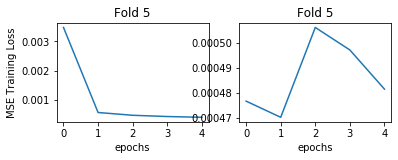

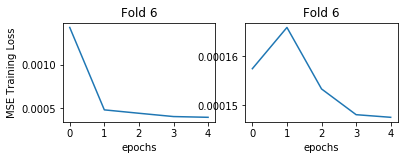

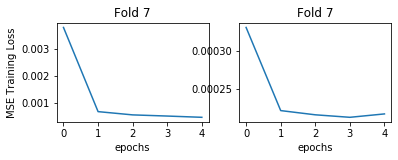

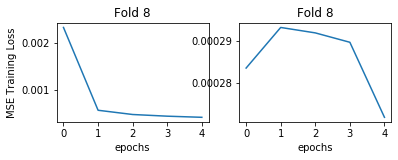

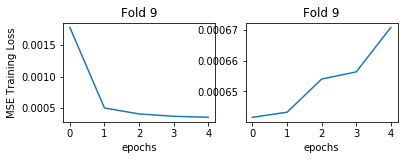

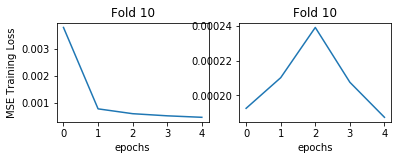

In [22]:
from matplotlib import pyplot as plt

for i,history in enumerate(historiesStacked):
    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.title("Fold " + str(i+1))
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.title("Fold " + str(i+1))

    plt.xlabel('epochs')
    plt.show()

# Backtracing

Backtracing is a useful technique to visualize the results of our predictions on the actual dataset. The previous 90 days will be graphed along with the predicted values compared to the actual values. This technique will allow us to determine which patterns the RNN is poor at predicting, which will help give us clarity on how to improve the model beyond looking at convergence metrics. 

# Backtracing GRU Prediction vs Real

90


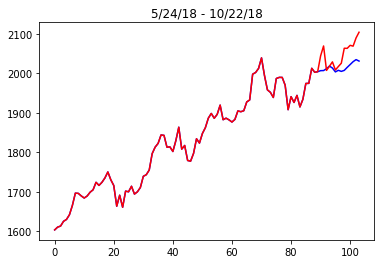

In [47]:
base = 1274
timeplus = 231

yhat = gruModels[9].predict(xtime[base +timeplus][np.newaxis,:,:])

# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
print(len(backtesting))
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Backtracing for LSTM and Real

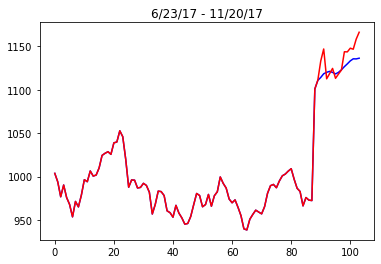

In [40]:
base = 1274
timeplus = 0
yhat = lstmModels[9].predict(xtime[base+timeplus][np.newaxis,:,:])

# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Backtracing for Stacked GRU and Real

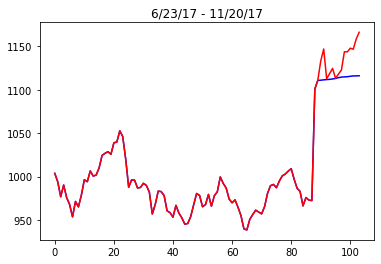

In [42]:
base = 1274
timeplus = 0
yhat = stackedModels[5].predict(xtime[base+timeplus][np.newaxis,:,:])

# print(yhat[0] - y_test[0])
backtesting = og[base-90+timeplus:base+timeplus]
yhatBack=og[base-1+timeplus]
ytestBack = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]

for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    yhatBack = yhatBack * (1+val)
    
    backtesting.append(yhatBack)

for i,val in enumerate(y_test[0].ravel()):
#     print(ytestBack)
    ytestBack = ytestBack * (1+val)
    
    ytest_backtesting.append(ytestBack)
xbacktest= [x for x in range(0,104)]
plt.plot(xbacktest,backtesting,'b-')
plt.plot(xbacktest,ytest_backtesting,'r-')
plt.title("{} - {}".format(ogdates[base-90+timeplus],ogdates[base+14+timeplus]))

plt.show()


# Extra Credit - Trading Algorithm

The basis of this algorithm is to buy if the prediction belives that the value of the next day will be greater than the current day and vice versa for selling. The ending value will be whatever the algorithm finally sells for on the last day. The algorithm we are comparing to is a simple buy and hold technique over the 14 day period. The time plus variable merely selects a starting point within the x data. Results are returned at the bottom

In [55]:
#making fake data
base = 1274
timeplus = 0
starting_price = og[base-1+timeplus]
price = og[base-1+timeplus]
ytest_backtesting=og[base-90+timeplus:base+timeplus]
prices = []
for i,val in enumerate(yhat[0].ravel()):
#     print(yhatBack)
    price = price * (1+val)
    
    prices.append(price)
daysPredicted = 14
testArr=[]
for val in range(daysPredicted):
    testArr.append(stackedModels[5].predict(xtime[base + val][np.newaxis,:,:])[0].ravel())

# print(testArr)
# testArr = [[0.2,0.3,-0.2],[0.3,-0.2,0.4],[-0.2,0.4,0.25],[0.4,0.25,-0.1],[0.25,-0.1,-0.2]]
# print(prices)
#start with owning 1 share
bought = True
#owns 1 share
value = 1
#index of time from where we are predicting 
price_index = 0
for i in range(daysPredicted-1,len(testArr)):
    val_for_next_day = 0
    # i2 is for traversing back the amount of days predicted
    i2 = i
    # i3 is for moving to the right position in the specific day to get the next days prediction 
    i3 = 0
    # it starts at 1, goes to 2, and then goes to 3
    # This will predict the next day 
    # [[*,*,3],[*,2,*],[1,*,*]]
    while(i2 > i-daysPredicted):
        val_for_next_day += testArr[i2][i3] * 1/daysPredicted
        i2-=1
        i3+=1
    # if the value for the next day is positive and we haven't bought then we buy
    if(val_for_next_day > 0 and not bought):
        bought = True
        print('bought at',price)
        value = value / price
    # if the value for the next day is negative and we own shares then we sell
    if(val_for_next_day < 0 and bought):
        bought = False
        print('sold at at',price)
        value = price * value
    # set the value to the next closing price
    price_index +=1
    price = prices[price_index]

if(bought):
    value = price * value

#this was made assuming you bought 1 share
print(' Staring Value:',starting_price,'\n',
      'Value of trading alorithm:', value, '\n',
      'Value of buying and holding:',(1*prices[-1]))
#technically we can own fractional parts of share with this algo


 Staring Value: 1110.849976 
 Value of trading alorithm: 1112.4607994077728 
 Value of buying and holding: 1125.8101595603712
